In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder,OrdinalEncoder

In [2]:
df = pd.read_csv('diabetes_probability.csv')
df.head()

,Unnamed: 0,age,gender,bmi,bmi_category,systolic,diastolic,blood_pressure_category,cholesterol,cholesterol_category,glucose,diabetes_probability
0,0,55,Female,29.59,Overweight,112.0,89.5,Hypertension Stage 1,247,High,139,0.65
1,1,34,Male,30.68,Obesity,106.0,115.0,Hypertension Stage 2,255,High,101,0.60
2,2,26,Male,15.96,Underweight,96.0,97.0,Hypertension Stage 2,234,Borderline high,97,0.15
3,3,63,Male,15.61,Underweight,109.6,115.3,Hypertension Stage 2,261,High,143,0.70
4,4,37,Male,41.54,Obesity,110.0,103.0,Hypertension Stage 2,226,Borderline high,115,0.50


In [6]:
# remove duplicates or null values if available
df.drop_duplicates(inplace=True,ignore_index=True)
df.dropna(inplace=True,ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               10000 non-null  int64  
 1   age                      10000 non-null  int64  
 2   gender                   10000 non-null  object 
 3   bmi                      10000 non-null  float64
 4   bmi_category             10000 non-null  object 
 5   systolic                 10000 non-null  float64
 6   diastolic                10000 non-null  float64
 7   blood_pressure_category  10000 non-null  object 
 8   cholesterol              10000 non-null  int64  
 9   cholesterol_category     10000 non-null  object 
 10  glucose                  10000 non-null  int64  
 11  diabetes_probability     10000 non-null  float64
dtypes: float64(4), int64(4), object(4)
memory usage: 937.6+ KB


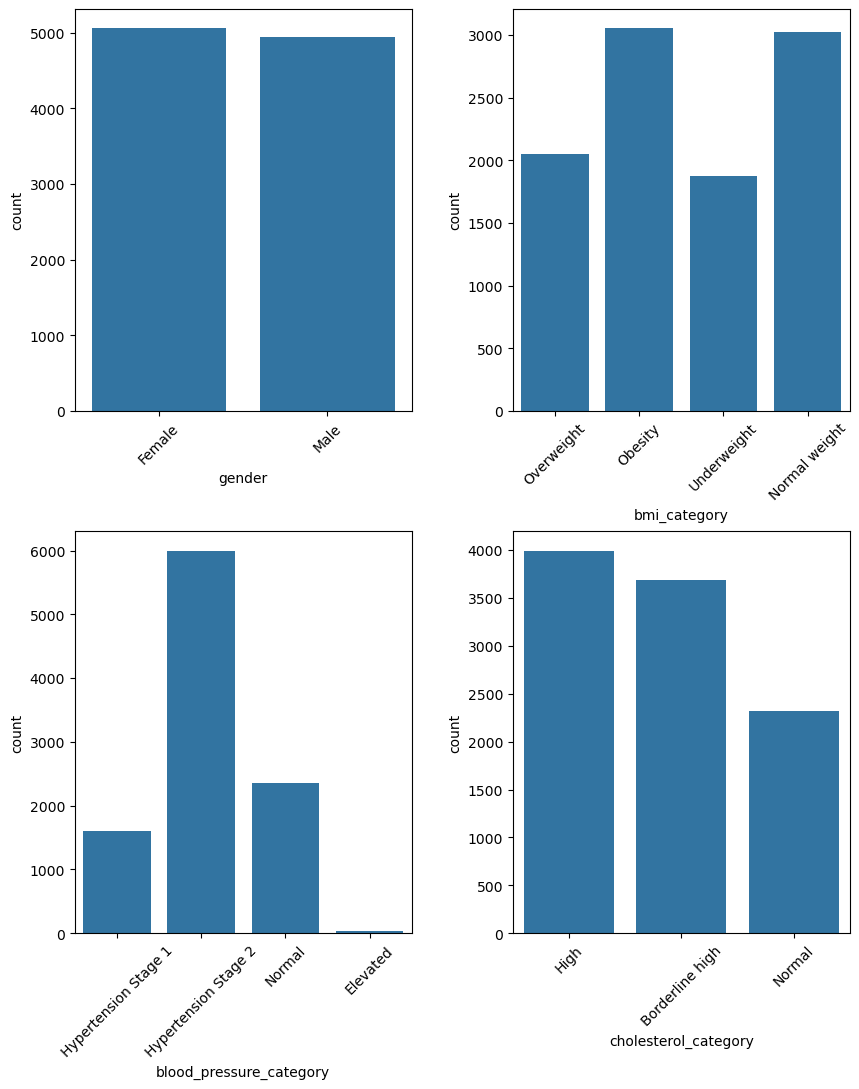

In [17]:
# plot categorical columns to understand unique values and their counts
cat_cols = df.select_dtypes(include='object').columns
ncols = 2
nrows = len(cat_cols) // ncols
plt.subplots(nrows,ncols,figsize=(10,12))
plt.subplots_adjust(wspace=0.3,hspace=0.3)
for i,col in enumerate(cat_cols):
    plt.subplot(nrows,ncols,i+1)
    sns.countplot(x=col,data=df)
    plt.xticks(rotation=45)

plt.show()

In [20]:
# split data
X = df.drop(columns=['diabetes_probability'])
y = df['diabetes_probability']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, y_train.shape

((8000, 11), (8000,))

In [30]:
# preprocess data
ct = ColumnTransformer(transformers=[
                            ('std_scaler',StandardScaler(),['age','cholesterol','glucose']),     # integer values
                            ('min_max_scaler',MinMaxScaler(),['bmi','systolic','diastolic']),    # float values
                            ('one_hot_encoder',OneHotEncoder(drop='first',handle_unknown='ignore',sparse_output=False),['gender']),
                            ('ordinal_encoder',OrdinalEncoder(categories=[
                                ['Underweight','Normal weight','Overweight','Obesity'],
                                ['Elevated','Normal','Hypertension Stage 1','Hypertension Stage 2'],
                                ['Normal','High','Borderline high']]),
                             ['bmi_category','blood_pressure_category','cholesterol_category'])],
                       remainder='passthrough',sparse_threshold=0)  
ct

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('std_scaler', StandardScaler(),
                                 ['age', 'cholesterol', 'glucose']),
                                ('min_max_scaler', MinMaxScaler(),
                                 ['bmi', 'systolic', 'diastolic']),
                                ('one_hot_encoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['gender']),
                                ('ordinal_encoder',
                                 OrdinalEncoder(categories=[['Underweight',
                                                             'Normal weight',
                                                             'Overweight',
                                                             'Obesity'],
                                                            ['Elevated',
                                                             'Normal',
                                                             'Hypertension '
                                                             'Stage 1',
                                                             'Hypertension '
                                                             'Stage 2'],
                                                            ['Normal', 'High',
                                                             'Borderline '
                                                             'high']]),
                                 ['bmi_category', 'blood_pressure_category',
                                  'cholesterol_category'])])

In [31]:
# build model
model = Pipeline(steps=[('processor',ct),('decision_tree',DecisionTreeRegressor())])
model

Pipeline(steps=[('processor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('std_scaler',
                                                  StandardScaler(),
                                                  ['age', 'cholesterol',
                                                   'glucose']),
                                                 ('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['bmi', 'systolic',
                                                   'diastolic']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['gender']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[['Underweight',
                                                                              'Normal '
                                                                              'weight',
                                                                              'Overweight',
                                                                              'Obesity'],
                                                                             ['Elevated',
                                                                              'Normal',
                                                                              'Hypertension '
                                                                              'Stage '
                                                                              '1',
                                                                              'Hypertension '
                                                                              'Stage '
                                                                              '2'],
                                                                             ['Normal',
                                                                              'High',
                                                                              'Borderline '
                                                                              'high']]),
                                                  ['bmi_category',
                                                   'blood_pressure_category',
                                                   'cholesterol_category'])])),
                ('decision_tree', DecisionTreeRegressor())])

In [32]:
# train model
model.fit(X_train,y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('processor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('std_scaler',
                                                  StandardScaler(),
                                                  ['age', 'cholesterol',
                                                   'glucose']),
                                                 ('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['bmi', 'systolic',
                                                   'diastolic']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['gender']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[['Underweight',
                                                                              'Normal '
                                                                              'weight',
                                                                              'Overweight',
                                                                              'Obesity'],
                                                                             ['Elevated',
                                                                              'Normal',
                                                                              'Hypertension '
                                                                              'Stage '
                                                                              '1',
                                                                              'Hypertension '
                                                                              'Stage '
                                                                              '2'],
                                                                             ['Normal',
                                                                              'High',
                                                                              'Borderline '
                                                                              'high']]),
                                                  ['bmi_category',
                                                   'blood_pressure_category',
                                                   'cholesterol_category'])])),
                ('decision_tree', DecisionTreeRegressor())])

In [33]:
# evaluate model with r2
model.score(X_test,y_test)

0.9972672459434064

In [35]:
# save model
joblib.dump(model,'Diabetes_Predictions.joblib')

['Diabetes_Predictions.joblib']

In [36]:
# save the cleaned data
df.to_csv('diabetes_probability.csv')